# DIA on DC2: Using Run2.1i

Owner: Bruno S.  (Duke U.)
Date: 21/01/2020

### Brief introduction

Difference image analysis is the standard technique to uncover variability and transient events on images. Here we show some work done with the SN sample present in WFD.

In this analysis we will find out what does the Run2.1i DIA dataset looks like.  
For this we will use a set of templates built for the purpouse as well as difference images already calculated, their association catalogs, and see what we can find.

In [1]:
import os
import numpy as np
import pandas as pd

import astropy.coordinates as SkyCoord
import astropy.units as u

from astropy import time
from collections import OrderedDict as Odict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lsst.afw.geom as afwGeom
import lsst.geom as geom

In [4]:
from lsst.afw.geom import makeSkyWcs
from lsst.daf.persistence import Butler
from lsst.obs.lsst.imsim import ImsimMapper

Here we create a butler for the difference image dataset for Run2.1i

This dataset has been built through several steps, and the following graph shows roughly the steps involved.

<img src='./plots/processing_schema.png' style="height:550px;">

In [5]:
calexprepo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1' 
b = Butler(calexprepo)
skymap = b.get('deepCoadd_skyMap')

Using the `calexp` repo we can ge the `skyMap` that is useful for analyzing the `tract` and `patch` to use. 

In this case we are going to work with tract-patch (from now on I will refer to this as `t+p`) `4431`,  `(1, 5)`.

In [6]:
tract = 4432
patch = (4, 3)

In [7]:
tract_info = skymap[tract]
tract_info

TractInfo(id=4432, ctrCoord=[0.45709432641562064, 0.7144995461958866, -0.5296745937313986])

In [8]:
tract_patch_box = tract_info.getPatchInfo(patch).getOuterBBox()
tract_patch_pos_list = tract_patch_box.getCorners()
# Cast to Point2D, because pixelToSky below will refuse to work with a Point2I object.
tract_patch_pos_list = [afwGeom.Point2D(tp) for tp in tract_patch_pos_list]

wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [9]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [10]:
print('Coordinate borders for patch\n  {:3.2f} < R.A. < {:3.2f} \n {:3.2f} < Dec < {:3.2f}'.format(min_ra, max_ra, min_dec, max_dec))

Coordinate borders for patch
  56.99 < R.A. < 57.27 
 -32.10 < Dec < -31.87


Just for fun, we make the calculation of the approximated area of this patch:

In [11]:
delta_ra, delta_dec = max_ra-min_ra, max_dec-min_dec
area = np.cos(np.deg2rad(min_dec+delta_dec*0.5))*np.deg2rad(delta_ra)*np.deg2rad(delta_dec)*180.*180./(np.pi**2.)*u.deg*u.deg
print('Area = {:4.3f} deg^2, or {:3.2f} arcmin^2'.format(area, area.to(u.arcmin**2)))

Area = 0.055 deg2 deg^2, or 196.85 arcmin2 arcmin^2


We can build the data id for this patch

In [12]:
tpId = {'tract': 4432, 'patch': '4,3'}

We will now acces to the repo of data we have for the difference images at the latest stage, the forced photometry.

Using this butler we can access data from every parent repo, ranging from the `calexp` until the forced photometry results.  


In [13]:
template_repo = '/global/cscratch1/sd/bos0109/templates_rect'
diarepo = template_repo + '/rerun/diff_rect'
assocrepo = diarepo + '/rerun/assoc_sha'
forcerepo = assocrepo + '/rerun/forcedPhot' 
tmprepo = template_repo + '/rerun/multiband'

diabutler = Butler(forcerepo)

Let's check, which data types can we obtain?

In [14]:
diaMapper = diabutler._getDefaultMapper()
mapper = diaMapper(root=forcerepo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

Now we are going to ask for the `diaSrc` detections, these are the individual sources that come from the difference images.
Let's ask for similar datatypes stored in our shortlist

In [15]:
[datatype for datatype in shortlist if 'dia' in datatype]

['dcrDiff_diaSrc',
 'deepDiff_diaObject',
 'deepDiff_diaSrc',
 'deepDiff_forced_diaObject',
 'deepDiff_forced_diaSrc']

Let's ask for the `deepDiff_diaSrc`

In [16]:
diabutler.getKeys('deepDiff_diaSrc')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

This means that for the butler to be able to gives our dataset we need to specify some of the id components above.

We have several files in the repo, and we can look for a visit and detector:

In [17]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/v00159479-fg/R03

diaSrc_00159479-g-R03-S01-det019.fits  diffexp_00159479-g-R03-S01-det019.fits
diaSrc_00159479-g-R03-S02-det020.fits  diffexp_00159479-g-R03-S02-det020.fits
diaSrc_00159479-g-R03-S11-det022.fits  diffexp_00159479-g-R03-S11-det022.fits
diaSrc_00159479-g-R03-S12-det023.fits  diffexp_00159479-g-R03-S12-det023.fits
diaSrc_00159479-g-R03-S21-det025.fits  diffexp_00159479-g-R03-S21-det025.fits
diaSrc_00159479-g-R03-S22-det026.fits  diffexp_00159479-g-R03-S22-det026.fits


In [18]:
srcs = [diabutler.get('deepDiff_diaSrc', visit=159479, detector=det).asAstropy().to_pandas() 
        for det in [19, 20, 22, 23, 25, 26]]
srcs = pd.concat(srcs)

In [19]:
srcs.head()

,id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,...,ip_diffim_DipoleFit_flag_classification,ip_diffim_DipoleFit_flag_classificationAttempted,ip_diffim_DipoleFit_flag,ip_diffim_DipoleFit_flag_edge,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge
0,10702455796924482,0.990591,-0.559641,0,False,2879.226758,76.890006,False,False,False,...,False,False,True,False,47255.123322,275.380883,79.065277,False,False,False
1,10702455796924483,0.990634,-0.560142,0,False,2359.451828,113.387111,False,False,False,...,True,True,False,False,395033.950993,758.915701,80.046303,False,False,False
2,10702455796924484,0.990643,-0.560074,0,False,2432.064832,122.173750,False,False,False,...,False,False,True,False,51342.315381,288.829790,79.893547,False,False,False
3,10702455796924485,0.990764,-0.559227,0,False,3306.708032,228.845880,False,False,False,...,True,True,False,False,92037.121802,408.110399,78.401138,False,False,False
4,10702455796924486,0.990781,-0.558900,0,False,3643.192083,246.080949,False,False,False,...,False,False,True,False,84463.946757,382.122665,77.802658,False,False,False


Let's plot the positions of the sources:

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


Text(32.99574835845665, 0.5, 'Dec')

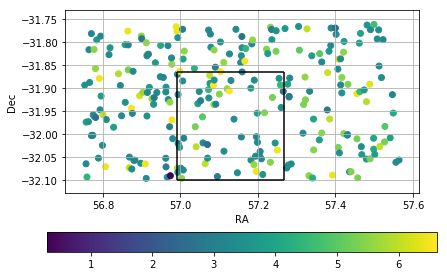

In [20]:
plt.scatter(np.rad2deg(srcs['coord_ra']), np.rad2deg(srcs['coord_dec']), 
            c=np.log10(srcs['base_PsfFlux_instFlux']))
plt.colorbar(orientation='horizontal')
plt.grid()
plt.vlines(x=[max_ra, min_ra], ymin=min_dec, ymax=max_dec)
plt.hlines(y=[max_dec, min_dec], xmin=min_ra, xmax=max_ra)
plt.gca().set_aspect(1./np.cos(np.mean([max_dec, min_dec])))
plt.tight_layout()
plt.xlabel('RA')
plt.ylabel('Dec')

A simple histogram of its fluxes

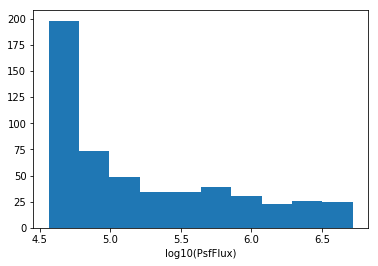

In [21]:
plt.hist(np.log10(srcs['ip_diffim_forced_PsfFlux_instFlux']))
plt.xlabel('log10(PsfFlux)')
plt.show()

We can also check the aperture fluxes, using different sizes of aperture.

In [22]:
[acol for acol in srcs.columns if 'Aperture' in acol and 'instFlux' in acol]

['base_CircularApertureFlux_3_0_instFlux',
 'base_CircularApertureFlux_3_0_instFluxErr',
 'base_CircularApertureFlux_4_5_instFlux',
 'base_CircularApertureFlux_4_5_instFluxErr',
 'base_CircularApertureFlux_6_0_instFlux',
 'base_CircularApertureFlux_6_0_instFluxErr',
 'base_CircularApertureFlux_9_0_instFlux',
 'base_CircularApertureFlux_9_0_instFluxErr',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_CircularApertureFlux_17_0_instFlux',
 'base_CircularApertureFlux_17_0_instFluxErr',
 'base_CircularApertureFlux_25_0_instFlux',
 'base_CircularApertureFlux_25_0_instFluxErr',
 'base_CircularApertureFlux_35_0_instFlux',
 'base_CircularApertureFlux_35_0_instFluxErr',
 'base_CircularApertureFlux_50_0_instFlux',
 'base_CircularApertureFlux_50_0_instFluxErr',
 'base_CircularApertureFlux_70_0_instFlux',
 'base_CircularApertureFlux_70_0_instFluxErr']

In [23]:
apertures = ['3_0', '4_5', '6_0', '9_0', '12_0', '17_0', '25_0', '35_0', '50_0', '70_0']

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


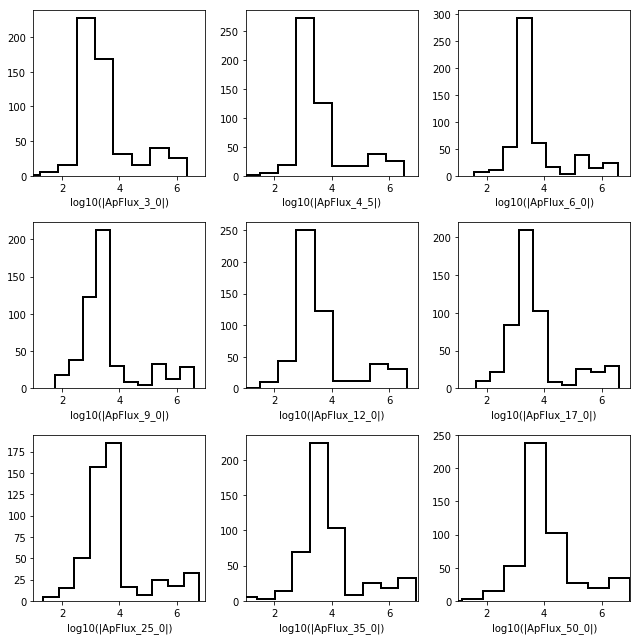

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(9,9))

for ax, ap in zip(axes.flatten(), apertures[:-1]):
    colname = 'base_CircularApertureFlux_{}_instFlux'.format(ap)
    ax.hist(np.log10(np.abs(srcs[colname])), color='k', histtype='step', lw=2)
    ax.set_xlabel('log10(|ApFlux_{}|)'.format(ap))
    ax.set_xlim(1, 7)
plt.tight_layout()
plt.show()

## Making lightcurves

In order to make lightcurves we will need to use the `diaObject` table. Let's open one of those

In [25]:
objs = diabutler.get('deepDiff_diaObject', dataId=tpId).asAstropy().to_pandas()

In [26]:
objs.head()

,id,coord_ra,coord_dec,parent,nobs,base_PsfFlux_instFlux_MeanErr_u,base_PsfFlux_instFlux_Ndata_u,base_PsfFlux_instFlux_Sigma_u,base_PsfFlux_instFlux_Mean_u,base_PsfFlux_instFlux_MeanErr_g,...,base_PsfFlux_instFlux_Sigma_i,base_PsfFlux_instFlux_Mean_i,base_PsfFlux_instFlux_MeanErr_z,base_PsfFlux_instFlux_Ndata_z,base_PsfFlux_instFlux_Sigma_z,base_PsfFlux_instFlux_Mean_z,base_PsfFlux_instFlux_MeanErr_y,base_PsfFlux_instFlux_Ndata_y,base_PsfFlux_instFlux_Sigma_y,base_PsfFlux_instFlux_Mean_y
0,19492704777928705,0.996160,-0.556281,0,4,0.0,1,0.0,126.71170,NaN,...,0.0,NaN,NaN,2,NaN,NaN,NaN,0,NaN,NaN
1,19492704777928706,0.995786,-0.556732,0,10,NaN,2,NaN,NaN,NaN,...,NaN,NaN,0.000000,1,0.000000,56.628015,NaN,0,NaN,NaN
2,19492704777928707,0.996325,-0.556657,0,23,0.0,1,0.0,NaN,71.020847,...,NaN,NaN,NaN,7,NaN,NaN,NaN,0,NaN,NaN
3,19492704777928708,0.996595,-0.557003,0,9,0.0,1,0.0,NaN,0.000000,...,NaN,NaN,115.999026,2,164.047396,865.957582,NaN,0,NaN,NaN
4,19492704777928709,0.996341,-0.557375,0,6,0.0,1,0.0,23698.37528,NaN,...,NaN,NaN,147.328294,2,208.353672,1030.790957,NaN,0,NaN,NaN


As you can see there are several columns for each one of these `diaObject` and they show information that can have empty information or important data in them.  
This depends in the group of `diaSrc` that each `diaObject` is associating. The column which knows about how many observations this is grouping is `nobs`: 

In [27]:
objs.nobs.describe()

count    605.000000
mean       4.525620
std        7.332552
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max       48.000000
Name: nobs, dtype: float64

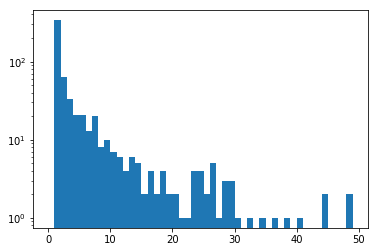

In [28]:
plt.hist(objs.nobs, bins=range(50), log=True)
plt.show()

As we can see there are some of them which actually have only 1 `diaSrc`, i.e. no association of sources at all.

If we want to know which sources are associated to each `diaObject` we need the table called `diaObjectId`, which we ask for now:

In [29]:
#objid = diabutler.get('deepDiff_diaObjectId', dataId=tpId).toDataFrame()

If the line above fails, might be due to different versions of the stack. The `diaObjectId` is a relatively new feature, and its creation is possible using the latest version of `dia_pipe`.

An alternative way of accessing the table is through the parquet tables, where this information comes from. This files are located in the associated piece of the repo directory tree:

In [30]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha/deepDiff/diaObject/4432/4,3

diaObject-4432-4,3.fits  diaObjectId-4432-4,3.parq


In [31]:
objId = pd.read_parquet('/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha/deepDiff/diaObject/4432/4,3/diaObjectId-4432-4,3.parq')

In [32]:
objId['nobs'] = objId.diaSrcIds.apply(len)

In [33]:
objId.head()

,diaObjectId,diaSrcIds,nobs
0,19492704777928705,"[157036352372778, 14169845574664303, 140280462...",4
1,19492704777928706,"[157038365638678, 14758315485560899, 130045647...",10
2,19492704777928707,"[157038365638679, 14758315485560905, 130045647...",23
3,19492704777928708,"[157038365638681, 14758315485560901, 130045647...",9
4,19492704777928709,"[157038365638683, 13248968817377403, 147587278...",6


As we can tell from the first rows, the table only hosts two columns and the `diaSrcIds` contains a list of the `diaSrcs` that are linked to a particular `diaObject`.
We also added the `nobs` column which is important to have it here too.
Let's work with the subset of `diaObject` with more sources associated!

In [36]:
subset_objs = objId[objId.nobs>=30]
subset_objs

,diaObjectId,diaSrcIds,nobs
6,19492704777928711,"[157038365638685, 14758315418451979, 130045647...",34
20,19492704777928725,"[14758315418451978, 13004564777140365, 1300718...",36
25,19492704777928730,"[14758315485560897, 13004564710031666, 1300718...",44
45,19492704777928750,"[13004564710031609, 13007182626816195, 1300724...",44
63,19492704777928768,"[13004564710031653, 13007182626816173, 1300724...",48
80,19492704777928785,"[13004564777140339, 13007182358380632, 1300724...",40
91,19492704777928796,"[13004564777140350, 13007182358380618, 1300724...",38
95,19492704777928800,"[13004564777140355, 13007182358380627, 1300724...",32
97,19492704777928802,"[13004564777140357, 13007245172277413, 1300745...",30
123,19492704777928828,"[13004564777140389, 13007182425489535, 1300724...",48


In [37]:
i_row = 0
print('the ID is : ', int(subset_objs.iloc[i_row]['diaObjectId']))

the ID is :  19492704777928711


Let's place it in our coordinate box.

In [38]:
selected_obj = objs[objs['id'] == int(subset_objs.iloc[i_row]['diaObjectId'])]

Text(24.602960532780145, 0.5, 'Dec')

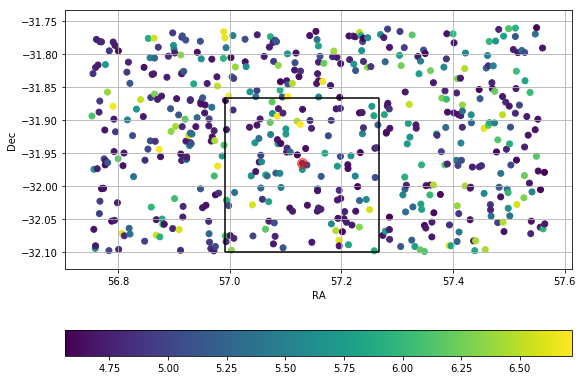

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(np.rad2deg(srcs['coord_ra']), np.rad2deg(srcs['coord_dec']), 
            c=np.log10(srcs['ip_diffim_forced_PsfFlux_instFlux']))
plt.colorbar(orientation='horizontal')
plt.scatter(np.rad2deg(selected_obj['coord_ra']), 
            np.rad2deg(selected_obj['coord_dec']),
            c='red', s=100, alpha=0.5)
plt.grid()
plt.vlines(x=[max_ra, min_ra], ymin=min_dec, ymax=max_dec)
plt.hlines(y=[max_dec, min_dec], xmin=min_ra, xmax=max_ra)
plt.gca().set_aspect(1./np.cos(np.mean([max_dec, min_dec])))
plt.tight_layout()
plt.xlabel('RA')
plt.ylabel('Dec')

The red dot shows which object we have chosen. 

In [41]:
selected_obj

,id,coord_ra,coord_dec,parent,nobs,base_PsfFlux_instFlux_MeanErr_u,base_PsfFlux_instFlux_Ndata_u,base_PsfFlux_instFlux_Sigma_u,base_PsfFlux_instFlux_Mean_u,base_PsfFlux_instFlux_MeanErr_g,...,base_PsfFlux_instFlux_Sigma_i,base_PsfFlux_instFlux_Mean_i,base_PsfFlux_instFlux_MeanErr_z,base_PsfFlux_instFlux_Ndata_z,base_PsfFlux_instFlux_Sigma_z,base_PsfFlux_instFlux_Mean_z,base_PsfFlux_instFlux_MeanErr_y,base_PsfFlux_instFlux_Ndata_y,base_PsfFlux_instFlux_Sigma_y,base_PsfFlux_instFlux_Mean_y
6,19492704777928711,0.997105,-0.557905,0,34,0.0,1,0.0,123.65359,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,NaN,NaN


Now, we select the data and start working to bring the `diaSrc` data altogether.  
So the list of `diaSrcs` associated is then:

In [42]:
objdrow = objId[objId.diaObjectId==int(selected_obj['id'])]

In [43]:
srcids = objdrow['diaSrcIds'].tolist()[0]
srcids

array([  157038365638685, 14758315418451979, 13004564777140361,
       13007182425489574, 13007245373604034, 13007454820368530,
       14872198221136015, 17066993081385062, 17069611065278690,
       17069815411769554, 17070692860166327, 17071020284313849,
       12204956085911742, 13012416983990372, 14232180314079377,
       14235545353846893, 14274737534402637, 14277150702043258,
       14758727869530205, 14758857389637739, 16803733933392046,
       11717344288047190, 11906596787454053, 11910485343469626,
       15292981804269644, 15293512434057309, 15295326856413275,
       15295721590751388, 16376115782221929, 17203230115102824,
         537342754422832, 12843098166001702, 15232705495040060,
       16309535534743612])

In [44]:
len(srcids)

34

In order to obtain the indiviual detections we must know the visit, and detector where each `diaSrc` was found. For this we need to use an inverse generation Id trick, which for Run2.1i is as follows:

In [45]:
visits = []
detectors = []
for asrcid in srcids:
    visit_id = (asrcid>>26)//1000
    visits.append(visit_id)
    detectors.append((asrcid>>26)%(1000*visit_id))
srcidstab = pd.DataFrame(np.array([srcids, visits, detectors]).T, columns=['srcid', 'visit', 'det'])

Also we would like to perform some sort of calibration for the individual fluxes. 

Below we are going to pull the `deepDiff_diaSrc` table where our source id is pointing to and also the `calexp` calibration.

In [46]:
fluxes_to_calibrate = ['base_PsfFlux_instFlux',
                       'ip_diffim_forced_PsfFlux_instFlux',
                       'base_CircularApertureFlux_3_0_instFlux',
                       'base_CircularApertureFlux_4_5_instFlux',
                       'base_CircularApertureFlux_6_0_instFlux',
                       'base_CircularApertureFlux_9_0_instFlux',
                       'base_CircularApertureFlux_12_0_instFlux', 
                       'base_CircularApertureFlux_17_0_instFlux', 
                       'base_CircularApertureFlux_25_0_instFlux']

In [47]:
rows = []
for idx, anid, avisit, adet in srcidstab.itertuples():
    sources_tab = diabutler.get('deepDiff_diaSrc', 
                                visit=avisit, detector=adet).asAstropy().to_pandas()
    photcal = diabutler.get('deepDiff_differenceExp_photoCalib', 
                           visit=avisit, detector=adet)
    calexp = diabutler.get('calexp', visit=avisit, detector=adet)
    date_mjd = calexp.getInfo().getVisitInfo().getDate().get()
    fltr = calexp.getInfo().getFilter().getCanonicalName()
    sources_tab['filter'] = fltr
    sources_tab['MJD'] = date_mjd
    source_row = sources_tab[sources_tab.id == anid].copy()
    for aflux in fluxes_to_calibrate:
        flux, err = source_row[aflux], source_row[aflux+'Err'] 
        #print(flux, err)
        cal = photcal.instFluxToMagnitude(flux, err)
        source_row[aflux+'_calMag'] = cal.value
        source_row[aflux+'_calMagErr'] = cal.error
        cal = photcal.instFluxToNanojansky(flux, err)
        source_row[aflux+'_nJy'] = cal.value
        source_row[aflux+'_nJyErr'] = cal.error
    rows.append(source_row)
lightcurve = pd.concat(rows)

Now we have a lightcurve table ready to plot:

In [48]:
lightcurve.head()

,id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,...,base_CircularApertureFlux_12_0_instFlux_nJy,base_CircularApertureFlux_12_0_instFlux_nJyErr,base_CircularApertureFlux_17_0_instFlux_calMag,base_CircularApertureFlux_17_0_instFlux_calMagErr,base_CircularApertureFlux_17_0_instFlux_nJy,base_CircularApertureFlux_17_0_instFlux_nJyErr,base_CircularApertureFlux_25_0_instFlux_calMag,base_CircularApertureFlux_25_0_instFlux_calMagErr,base_CircularApertureFlux_25_0_instFlux_nJy,base_CircularApertureFlux_25_0_instFlux_nJyErr
7,157038365638685,0.997104,-0.557905,0,False,3820.153139,1530.041342,False,False,False,...,-5291.882632,741.187786,NaN,0.221638,-4884.907963,997.185131,NaN,0.314487,-4875.225717,1412.125822
1,14758315418451979,0.997104,-0.557905,0,False,3775.095255,170.010942,False,False,False,...,4963.092935,713.627815,22.513066,0.286121,3587.350124,945.364096,23.33707,0.861677,1679.468331,1332.882842
28,13004564777140361,0.997105,-0.557905,0,False,144.124252,1246.036017,False,False,False,...,-9011.326641,311.926592,NaN,0.049346,-8922.798754,405.532341,NaN,0.066549,-9111.703148,558.488747
68,13007182425489574,0.997105,-0.557905,0,False,492.147061,3960.219595,False,False,False,...,-8539.452206,304.999827,NaN,0.050215,-8589.091855,397.242758,NaN,0.066672,-8895.878418,546.270798
3,13007245373604034,0.997105,-0.557905,0,False,583.176582,153.019026,False,False,False,...,-8642.391014,307.300625,NaN,0.050399,-8585.334724,398.522882,NaN,0.074195,-8018.634268,547.964883


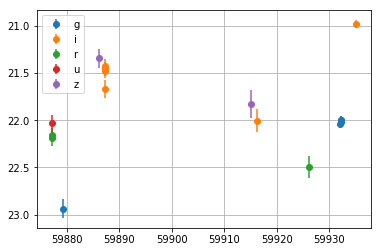

In [49]:
for fltr, lc in lightcurve.groupby('filter'):
    plt.errorbar(lc['MJD'], lc['base_CircularApertureFlux_6_0_instFlux_calMag'], 
                 yerr=lc['base_CircularApertureFlux_6_0_instFlux_calMagErr'],
                 label=fltr, fmt='o')
plt.grid()
plt.legend(loc='best')
plt.gca().invert_yaxis()

We could also use this to create stamps, but for the moment this is enough information!